In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

# global variables

In [2]:
# data points (1h) that the model recevies to predict next hour
time_interval = 24
# split train/test ratio
train_percent = 0.8
# number of hours that will be used to train
time_relevance = time_interval * 365 * 3

# load data

In [3]:
# df = pd.read_excel("../models/data/EsaveExportSmall.xls") # for github and small dataset
df = pd.read_excel("../../EsaveExportBig.xls") # local file. use above if not you are not me
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
datetime = df.pop("datetime")
df = df.dropna(axis=1, how="any")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))
df = df.iloc[:time_relevance]
channels = df.shape[1] # for later
print(channels)
df

81


,707057500068119547,707057500068755066,ESAVE_193681-980396002_EAN,707057500068789658,707057500068425556,707057500068402960,707057500068104048,707057500068744237,707057500068750269,707057500067764427,...,707057500068094592,707057500068742943,ESAVE_182900-980396002_EAN,707057500068702657,707057500068298990,707057500068614882,707057500068762040,707057500068392667,ESAVE_66267-980396002_EAN,707057500068415243
0,9.4,7.2,8.0,7.1,4.0,6.7,9.9,14.6,4.7,4.7,...,3.2,2.6,13.0,8.0,7.0,6.9,5.4,1.6,8.0,4.6
1,9.6,7.2,9.0,7.0,7.0,8.6,10.0,14.6,2.9,3.8,...,3.2,2.8,12.0,6.5,8.0,7.8,5.0,1.8,9.0,4.7
2,8.7,7.2,9.0,6.2,6.0,10.4,8.8,15.0,3.2,4.0,...,3.4,2.6,14.0,7.7,7.2,8.8,5.4,2.0,8.0,4.6
3,8.8,7.2,9.0,7.8,5.0,10.2,10.2,16.6,5.3,3.8,...,3.2,2.8,12.0,6.7,7.2,9.4,4.6,1.9,7.0,5.0
4,9.1,7.2,9.0,7.0,5.0,9.8,9.9,15.4,18.2,4.2,...,3.4,2.6,13.0,5.6,7.4,20.8,15.2,1.9,8.0,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,11.0,8.0,23.0,14.0,12.0,17.0,12.0,19.0,5.0,13.0,...,3.0,3.0,22.0,10.0,8.0,20.0,18.0,1.0,12.0,4.0
26276,11.0,7.0,25.0,15.0,14.0,16.0,13.0,19.0,13.0,13.0,...,3.0,2.0,19.0,10.0,11.0,19.0,14.0,2.0,13.0,4.0
26277,11.0,7.0,25.0,15.0,7.0,16.0,13.0,18.0,6.0,12.0,...,3.0,3.0,24.0,11.0,12.0,16.0,18.0,2.0,14.0,4.0
26278,13.0,7.0,25.0,15.0,8.0,18.0,12.0,20.0,3.0,13.0,...,3.0,3.0,22.0,10.0,12.0,19.0,15.0,1.0,13.0,4.0


# prepare labeled data

In [4]:
X = []
y = []
Xtest = []
ytest = []

for i in range(time_relevance -time_interval):
    xi = df.iloc[i:i+time_interval].values.reshape((time_interval,channels))
    yi = df.iloc[i+1].values
    X.append(xi)
    y.append(yi)
        
X = np.array(X)
y = np.array(y)

# mean and std for normalization. remember for decoding later
my = X.mean()
sigma = X.std()
X = (X - my)/sigma
y = (y - my)/sigma

split_index = int(X.shape[0] * train_percent)
Xtrain = X[:split_index]
ytrain = y[:split_index]

Xtest = X[split_index:]
ytest = y[split_index:]

del df, X, y # for memory

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)
print(Xtrain[0])
print(ytrain[0])

(21004, 24, 81) (21004, 81)
(5252, 24, 81) (5252, 81)
[[ 0.01196095 -0.23675752 -0.14631444 ... -0.86985908 -0.14631444
  -0.53069753]
 [ 0.03457172 -0.23675752 -0.03326059 ... -0.84724831 -0.03326059
  -0.51939214]
 [-0.06717674 -0.23675752 -0.03326059 ... -0.82463754 -0.14631444
  -0.53069753]
 ...
 [ 0.05718249 -0.21414675  0.07979326 ... -0.85855369 -0.03326059
  -0.50808676]
 [-0.03326059 -0.23675752  0.07979326 ... -0.84724831 -0.14631444
  -0.53069753]
 [ 0.05718249 -0.21414675  0.19284711 ... -0.83594292 -0.03326059
  -0.53069753]]
[ 0.03457172 -0.23675752 -0.03326059 -0.25936829 -0.25936829 -0.07848213
  0.07979326  0.59984097 -0.72288907 -0.62114061 -0.63244599  0.69028405
 -0.88116446  0.87117021 -0.56461368 -0.59852984  0.53200866 -0.5533083
  0.98422406  2.79308566 -0.48547599  0.30590096 -1.05074524  0.64506251
 -0.42894906 -0.14631444 -0.86985908 -1.05074524 -0.25936829  0.19284711
 -0.15761982  0.87117021 -0.41764368 -0.38372752 -0.68897292 -0.03326059
 -0.84724831  0.3

# define model and test forward

In [5]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=time_interval//4, activation='relu', input_shape=(time_interval, channels)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(channels))
model.compile(optimizer='adam', loss='mse')

# fit and test

In [6]:
print("before training:\n")
out = model.predict(Xtest[0].reshape((1,time_interval,channels)))
# out = out * sigma + my # example of decoding
print(out) # prediction
print(ytest[0]) # actual

monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 5)
model.fit(Xtrain, ytrain, epochs=40, verbose=1, validation_data=(Xtest, ytest), callbacks=[monitor_val_acc])

print("\nafter training:\n")
out = model.predict(Xtest[0].reshape((1,time_interval,channels)))
print(out) # prediction
print(ytest[0]) # actual

before training:

[[ 0.07001058  0.04721459  0.40212715  0.21010382  0.06760952 -0.13440652
  -0.1707979   0.24960934  0.19959657 -0.20006582  0.27262217  0.12770203
   0.3204547  -0.27811652  0.01758184  0.13863593 -0.22269753 -0.08826761
   0.05841805 -0.37770465  0.19135103  0.21573779 -0.04181702 -0.02123363
  -0.21054532 -0.6564868   0.17621468 -0.37563452 -0.02819701  0.02543667
   0.15067846 -0.05969176  0.12182058  0.10913877  0.1782304  -0.19701761
   0.38991085  0.13840649  0.05499566  0.01491383 -0.04724416  0.06592324
   0.22459279 -0.15684201 -0.23257357  0.02547014 -0.03141207 -0.11847195
  -0.2276456   0.39608985  0.21756701  0.12725435 -0.19438767  0.14295487
  -0.17396644 -0.42747536  0.11369045 -0.19426931  0.02389367  0.16292594
   0.18274236 -0.48926136 -0.02508576 -0.06340562 -0.43061572  0.1404965
  -0.3568573   0.2277334  -0.02679455 -0.32497752  0.22015391  0.49291503
  -0.06442019  0.50311244 -0.25691718  0.17592931 -0.4767783  -0.41401365
  -0.5084783   0.5699

# compare

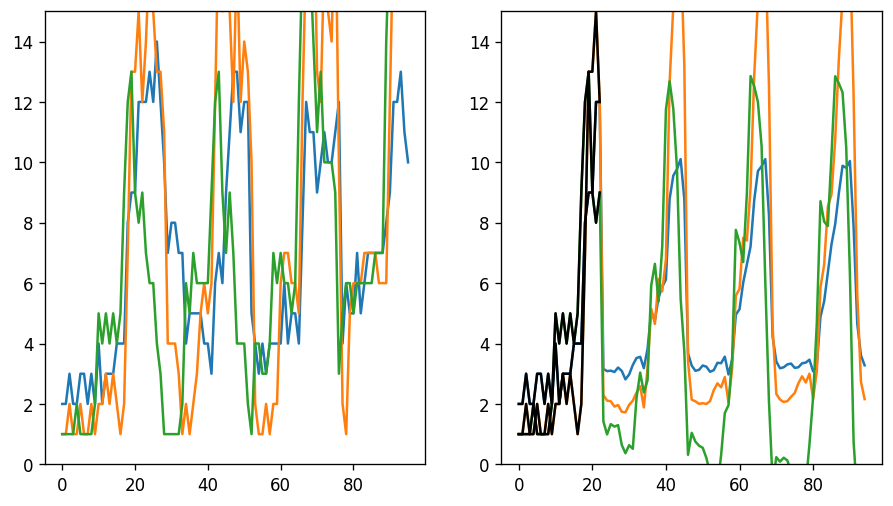

In [25]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, ax = plt.subplots(1,2)
ax[0].set_ylim([0,15])
ax[1].set_ylim([0,15])

start_idx = 80

autoreg = Xtest[start_idx] # never seen data to get it rolling
predicts = []
future_steps = time_interval * 3 # the amount of hours to predict
for i in range(future_steps): # predict next value, add it to autoreg, forget oldest value in autoreg
    predict = model.predict(autoreg.reshape((1,time_interval,channels)))
    predicts.append(predict)
    autoreg = np.concatenate((autoreg, predict))[1:]
    
predicts = np.array(predicts).reshape((future_steps,channels)) # all predicts done in autoreg loop
predicts = np.concatenate((Xtest[start_idx], predicts)) # all predicts done + the data given to get it rolling (colored black)

ax[0].plot(ytest[start_idx:start_idx+time_interval * 4,:3] * sigma + my) # the correct data
ax[1].plot(predicts[1:,:3] * sigma + my)
ax[1].plot(ytest[start_idx:start_idx+time_interval-1,:3] * sigma + my, color="black")
plt.show()

# idk

In [8]:
train_time = range(X.shape[0])
test_time = range(X.shape[0], X.shape[0] + Xtest.shape[0])
fig, ax = plt.subplots(1,2)

# predict data that was used for training
trained_predicts = model.predict(X)
# predict test data never seen
test_predicts = model.predict(Xtest)

ax[0].plot(train_time, trained_predicts)
ax[0].plot(test_time, test_predicts, color="black")

ax[1].plot(train_time, y)
ax[1].plot(test_time, ytest, color="purple")
    
print(trained_predicts.shape)
plt.show()

NameError: name 'X' is not defined